# Visualizing Models, Data, and Training with TensorBoard

Apart from loading the We loaded the data from the Fashion-MNIST, let's make sure we have the data transformation pipeline for pre-processing the images. It happens in the following steps:
1. Converts the Image to a PyTorch Tensor.
2. Scales the pixel intensity values from original integer range $(0, 255)$  to floating point number $(0, 1.0)$.
    * Centering the data around zero (mean ~ 0) and scaling it (std ~ 1) helps deep learning models converge faster and more stably during training by preventing input features from having vastly different magnitudes, which can lead to unstable gradients.
3. Reorder the image dimension order from the typical (Height x Width x Channels) format used by image libraries to the PyTorch standard of (Channels x Height x Width).
4. After the data has been converted to Tensor & Scaled to $(0, 1.0)$, the Normalization function standardizes the Tensor image by applying the formula: $output[channel] = \frac{input[channel] - mean[channel]}{std[channel]}$. The single value in the tuple, $(0.5,)$ for both mean and std, indicates that this transformation is intended for a single-channel image (grayscale, like the MNIST dataset). If it were a color image (RGB), there would be three values, e.g. $(0.5, 0.5, 0.5)$.
5. This specific normalization shifts the data range from $[0.0, 1.0]$ to $[-1.0, 1.0]$.
    * Original Min $(0.0)$: $(0.0 - 0.5)$ / $0.5$ = $-1.0$
    * Original Max $(1.0)$: $(1.0 - 0.5)$ / $0.5$ = $1.0$

In [17]:
# imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./fashion-mnist/data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./fashion-mnist/data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

# constant for classes: Tuple, with the labels present in the dataset, starting from 0 to 9
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


**Dataloader** forms the crucial part of the Data loading pipeline. It's main role is to efficiently feed data to your machine learning model during the training process. It uses an iterator over the entire training set randomly in a batch size of 4, which means each time 4 images will be loaded and processed by the model during the Training. In other words, Training will proceed by taking batches of 4, rather than processing the entire dataset at once. Selecting the images randomly during the Training Phase ensures that the data is randomly reordered every time the model iterates over the entire dataset (an epoch). 

***This is a best practice to prevent the model from learning the order of the samples, which can lead to poor generalization.***

**Benefits of Dataloader**: 
+ Batching: Automatically groups samples for efficient training on GPUs.
+ Shuffling: Randomizes data to ensure model robustness.
+ Parallelism (if specified): Can use multiple worker processes (num_workers) to load data in parallel, preventing the data loading step from being a bottleneck (a common issue known as the "data bottleneck").

**Classes** creates a tuple of ordered immutable list. The Class Names with 10 strings inside the tuple are the human-readable names corresponding to the integer labels (usually $0$ through $9$) that the machine learning model will predict.This mapping is essential for interpreting the model's output. For example, if the model predicts the label $5$, you use this tuple to know that the prediction corresponds to a 'Sandal'. 

### 1. Randomly Visualize Some Training Images

Both code blocks on helper functions #1 & #2 are utility functions designed to display a PyTorch image tensor using $Matplotlib$ after applying necessary transformations ($unnormalization$ and $dimension reordering$).

**Helper Function 1**
* Grayscale Display: If *one_channel* is True, the function displays the image using the "Greys" color map, which is appropriate for grayscale images.
* Color Display: If *one_channel* is False (for standard color images), the images are Transposed from (Channels x Height x Width), or (C, H, W): $(0, 1, 2)$ to (Height x Width x Channels), or (H, W, C): $(1, 2, 0)$ to match $Matplotlib's$ requirement.

**Helper Function 2**
* It is generally more robust and flexible, particularly in professional training environments. 
* It's also a better utility because it ensures the code works seamlessly whether the tensor is on the CPU or GPU, and it gives the user control over whether the $unnormalization$ is applied. 
* It also provides better control over the final presentation of the image within the notebook.

**PLotting Images**. 
* If tensors are on GPU, $img = img.cpu()$ explicitly moves the tensor to the CPU before converting to $numpy$.
* Use $labels.size(0)$ or $images.shape[0]$ instead of an undefined batch_size variable.
* If you normalized the images, $unnormalize$ before plotting ($imshow$ helper already does this).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


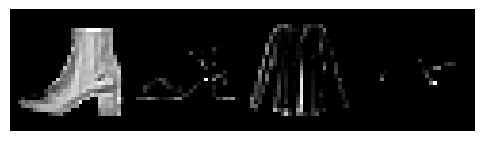

Ankle Boot Sandal Shirt Sandal


In [18]:
# # 1: helper function to show an image
# # (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# # 2: helper function to show an image; Better CPU-GPU compatibility
def imshow(img, unnormalize=True):
    # img: torch.Tensor from torchvision.utils.make_grid (C,H,W)
    if isinstance(img, torch.Tensor):
        img = img.cpu()
    if unnormalize:
        img = img / 2 + 0.5   # adjust if you normalized differently
    npimg = img.numpy()
    # plt.figure(figsize=(6,3))
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.axis('off')
    # plt.show()


# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

grid = torchvision.utils.make_grid(images)          # tensor CHW
grid = grid.cpu().numpy() 
plt.figure(figsize=(6,3))                           # to numpy
plt.imshow(np.transpose(grid, (1, 2, 0)))           # HWC for matplotlib
plt.axis('off')
plt.show()
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(labels.size(0))))

### 2. Convolutional Neural Network Architecture
[Convolution Neural Network (CNN) Architecture Diagram Reference](https://www.linkedin.com/pulse/what-convolutional-neural-network-cnn-deep-learning-nafiz-shahriar/)</cite>

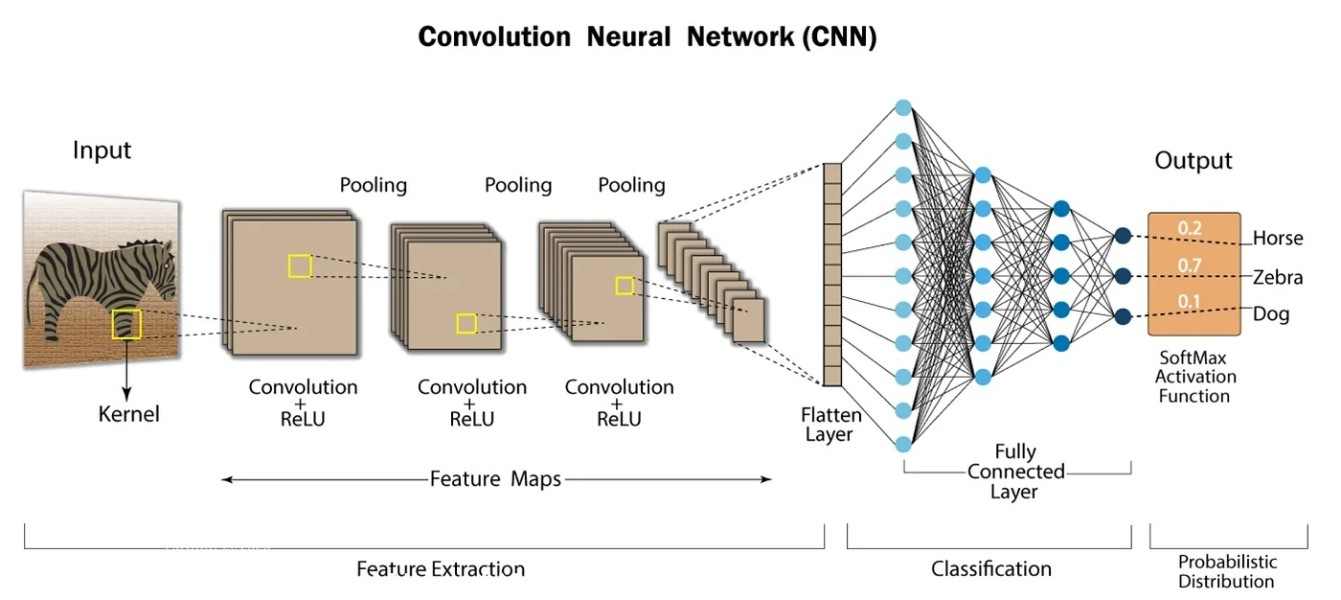

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 3. Define a Loss function and optimizer

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training Visualization

## A. Setting up with the TensorBoard 
Now we’ll set up TensorBoard, importing tensorboard from torch.utils and defining a SummaryWriter, our key object for writing information to TensorBoard.

In [21]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/fashion_mnist_experiment_1')

Note that this line alone creates a runs/fashion_mnist_experiment_1 folder.

## B. Writing to a TensorBoard
Now let’s write an image to our TensorBoard - specifically, a grid using $\texttt{make\_grid}$.

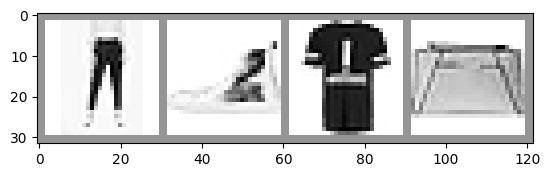

In [22]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

# C. Model Inspection Using TensorBoard
One of TensorBoard’s strengths is its ability to visualize complex model structures. Let’s visualize the model we built.

In [14]:
writer.add_graph(net, images)
writer.close()

On double clicking on “Net”, "Input", and "Output" lets it expand, with detailed view of the individual operations that make up the Neural Network model architecture.

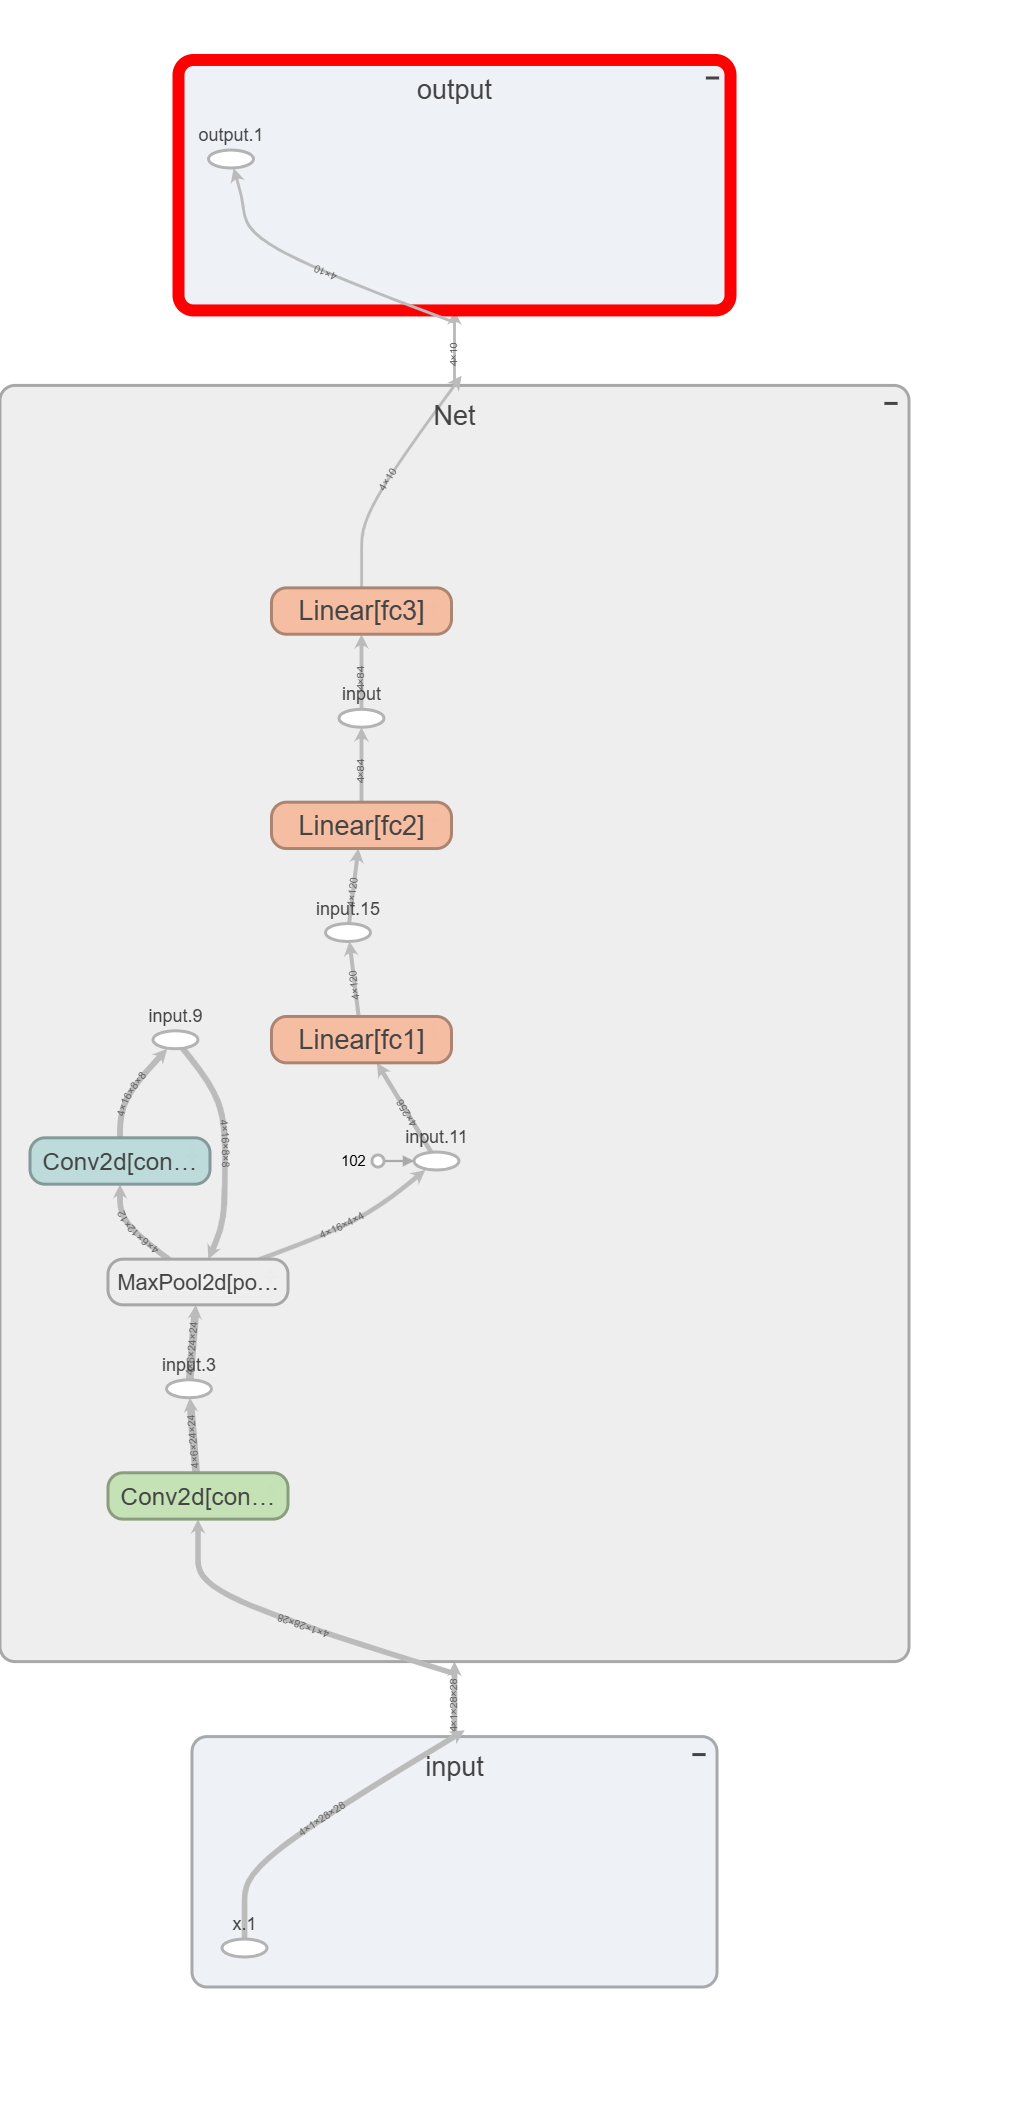

##### **TPU Compatibility Screenshot from the TensorBoard**

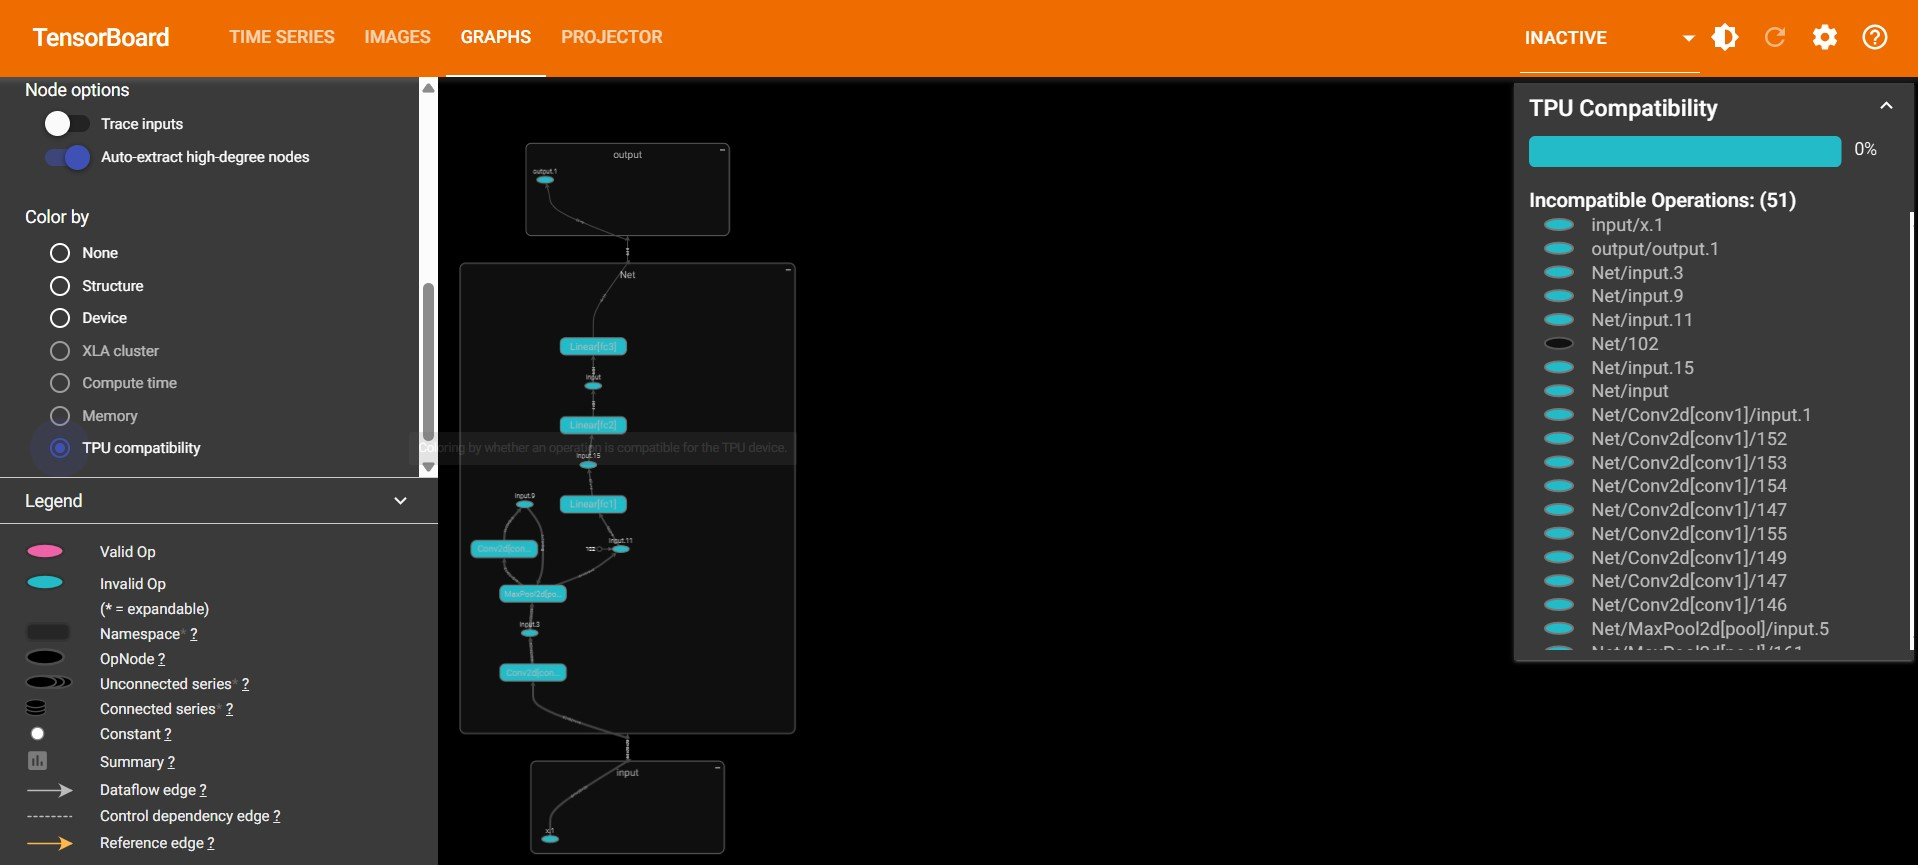

# D. Adding a "Projector" to TensorBoard
We can visualize the lower dimensional representation of higher dimensional data via the $\texttt{add\_embedding}$ method 

In [16]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()

##### **Projector Screenshot from the TensorBoard with PCA & Total Variance Described in 3D**

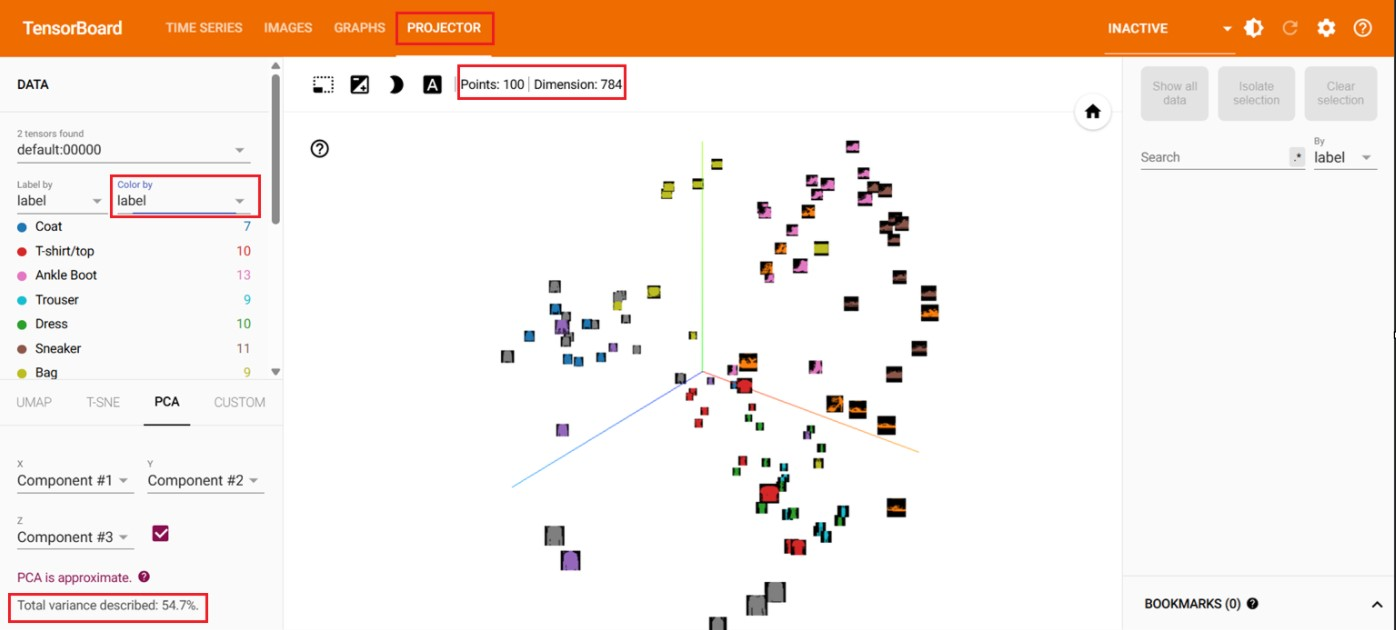

Now in the “Projector” tab of TensorBoard, you can see these 100 images - each of which is 784 dimensional - projected down into three dimensional space. Furthermore, this is interactive: you can click and drag to rotate the three dimensional projection. Finally, a couple of tips to make the visualization easier to see: select “color: label” on the top left, as well as enabling “night mode”, which will make the images easier to see since their background is white. 

You can also load your own tsv data to visualize in the Projector and download the tsv data file that is being used in the Projector to understand the data variance.

# E. Tracking Model Training with TensorBoard
In the previous example, we simply printed the model’s running loss every 2000 iterations. Now, we’ll instead log the running loss to TensorBoard, along with a view into the predictions the model is making via the $\texttt{plot\_classes\_preds}$ function.

In [25]:
# helper functions

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

Finally, let’s train the model using the same model training code from the prior tutorial, but writing results to TensorBoard every 1000 batches instead of printing to console; this is done using the $\texttt{add\_scalar}$ function.

In addition, as we train, we’ll generate an image showing the model’s predictions vs. the actual results on the four images included in that batch.

In [26]:
running_loss = 0.0
for epoch in range(1):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(net, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

Finished Training


##### **Model Training Tracking with Scalars**
+ The Model went through almost 14K Training iterations.
+ You can also smooth out the training curve based on the gradient or how much optimization would you like to infuse in your Model Training.

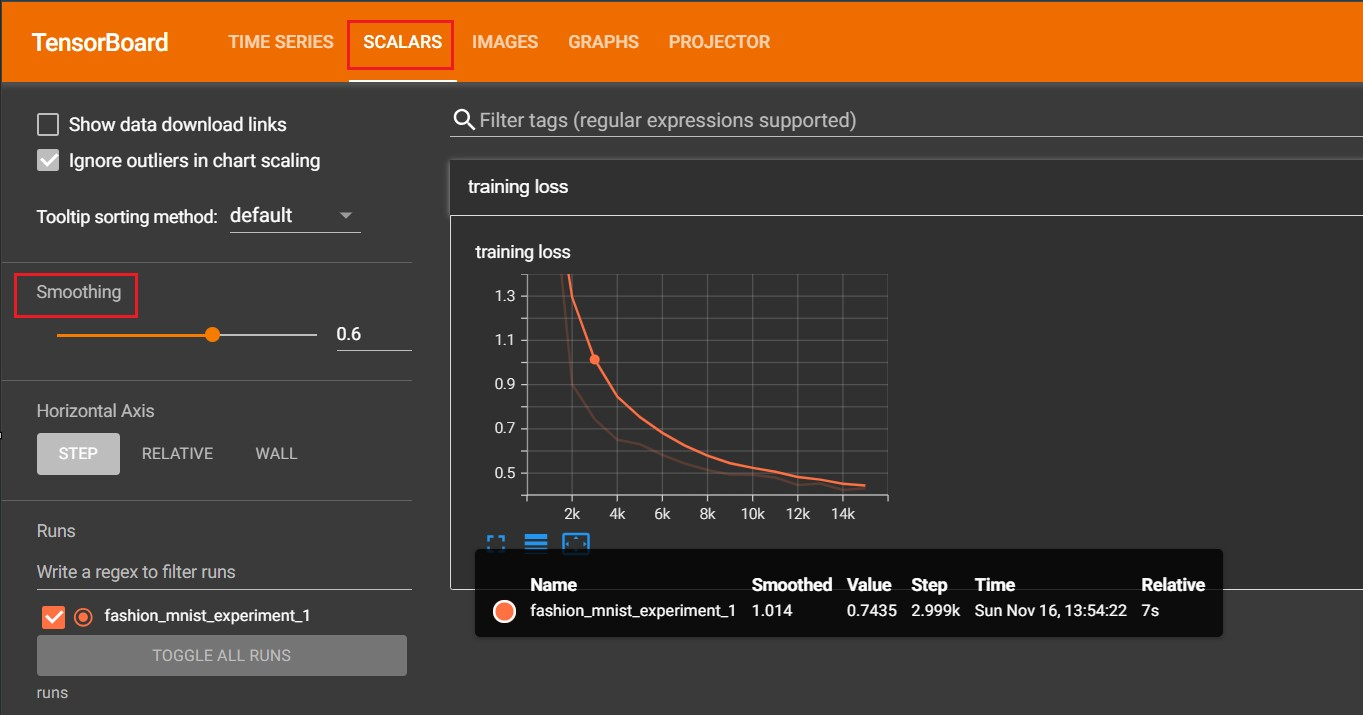

In addition, we can look at the predictions the model made on arbitrary batches throughout learning. See the “Images” tab and scroll down under the “predictions vs. actuals” visualization to see this; this shows us that, for example, after just 3000 training iterations, the model was already able to distinguish between visually distinct classes such as shirts, sneakers, and coats, though it isn’t as confident as it becomes later on in training:



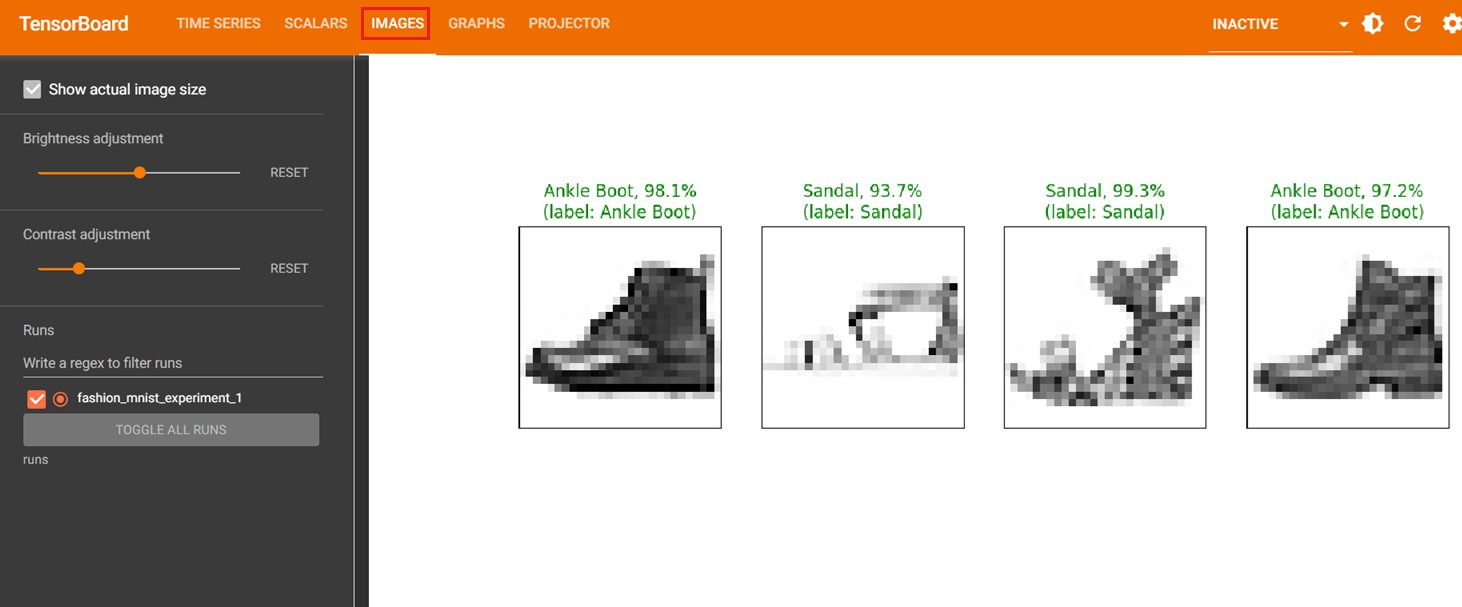

# F. Assessing Trained Models with TensorBoard
You will now see a “Precision Recall Curves” tab that contains the precision-recall curves for each class. Go ahead and poke around; you’ll see that on some classes the model has nearly 100% “area under the curve”, whereas on others this area is lower:

In [27]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
class_probs = []
class_label = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

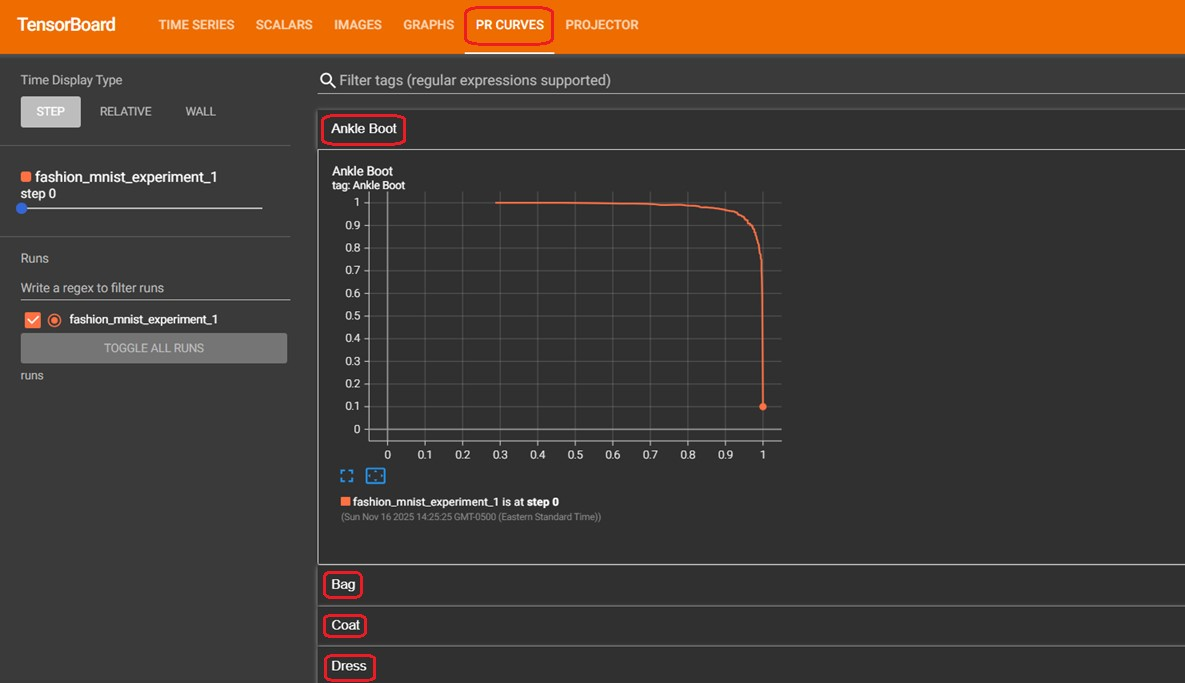

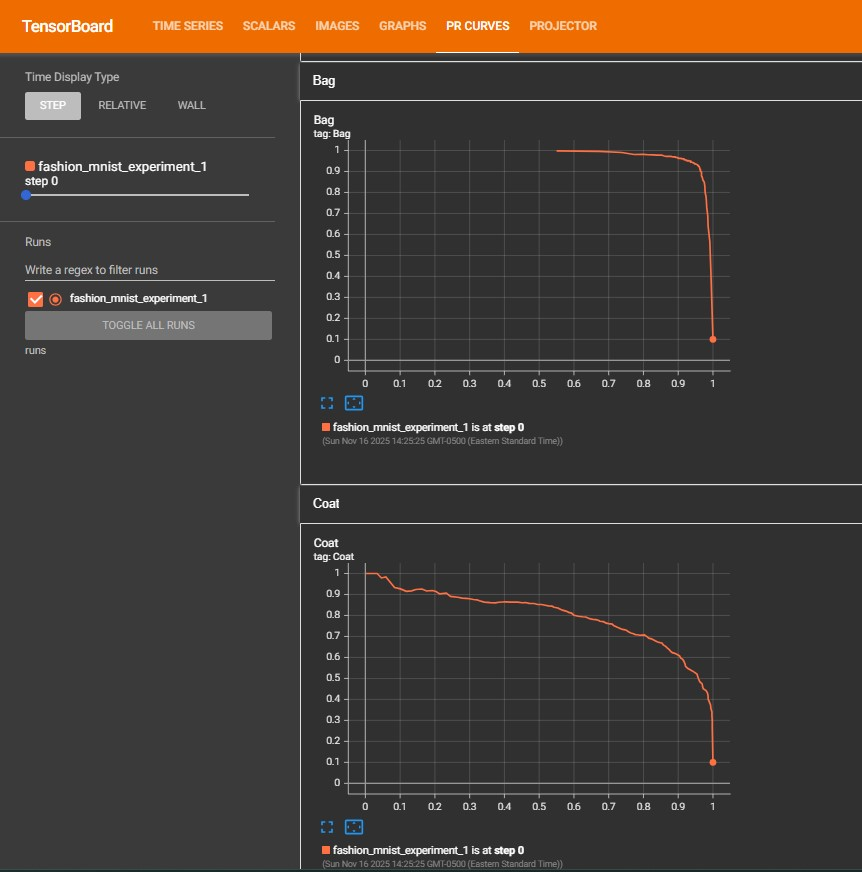